In [31]:
# !pip install open_clip_torch 
import open_clip
import torch
import matplotlib.pyplot as plt
import os
import json
from PIL import Image
from tqdm import trange
import numpy as np
from utils import time_gpu

from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize

In [2]:
model, _, preprocess = open_clip.create_model_and_transforms('ViT-bigG-14', pretrained='laion2b_s39b_b160k')
print(sum(p.numel() for p in model.parameters() if p.requires_grad)/1e9)

2.539567105


In [3]:
model.to(torch.bfloat16)
device  = torch.device('cuda')
model = model.to(device)

In [108]:
pth = '../cptData/llava/train2014/COCO_train2014_000000482499.jpg'
pth2 = '../cptData/llava/train2014/COCO_train2014_000000517899.jpg'

# open image using PIL and print its size

print(Image.open(pth).size, Image.open(pth2).size)

## convert image to numpy array and print its size

img = np.array(Image.open(pth))
img2 = np.array(Image.open(pth2))

print(img.shape, img2.shape)

(375, 500) (631, 640)
(500, 375, 3) (640, 631)


In [9]:
tokenizer = open_clip.get_tokenizer('ViT-B-32')

image = preprocess(Image.open('../cptData/llava/train2014/COCO_train2014_000000482499.jpg')).unsqueeze(0)
text = tokenizer(["a cave", "a cement bag", "a toilet"])

with torch.no_grad():
    image_features = model.encode_image(image.to(device).to(torch.bfloat16))
    text_features = model.encode_text(text.to(device))
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

print("Label probs:", text_probs)  # prints: [[1., 0., 0.]]

Label probs: tensor([[1.7643e-05, 5.0000e-01, 5.0000e-01]], device='cuda:0',
       dtype=torch.bfloat16)


In [27]:
# import numpy as np
# import sys
# import os
# import json
# from tqdm import trange

# pth = os.path.abspath(os.path.dirname(os.path.dirname(os.path.dirname("__file__"))))

# print(pth)
# ###################################################################################################                          

# ## LLaVA-Instruct-150K

# from datasets import load_dataset
# dataset = load_dataset("liuhaotian/LLaVA-Instruct-150K")

/root/data/nanoGPT


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 516.67it/s]


Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/liuhaotian___json/liuhaotian--LLaVA-Instruct-150K-1764f60a2e27bb0f/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4. Subsequent calls will reuse this data.


100%|██████████| 1/1 [00:00<00:00, 120.89it/s]


In [34]:
# data_cleaned = []

# for i in trange(len(dataset['train'])):
# # for i in range(12):
#     con = dataset['train'][i]['conversations']
#     con = "###User: " + con[0]['value'] + "\n###Bot:" + con[1]['value']
#     con = con.replace('<image>\n', '')
#     data_cleaned.append(con)
    
    
# sys.path.append(pth)
# from llamaTokenizer import LLaMAtokenizer

# tokenizer_path = os.path.join(os.path.dirname(pth), "cptData/lit-llama/tokenizer.model")

# train_frac = 0.9
# seq_len = 2048

# tokenizer = LLaMAtokenizer(model_path=tokenizer_path)
# enc = lambda s: tokenizer.encode(s, bos=False, eos=True)
# dec = lambda s: tokenizer.decode(s)

# encoded = [enc(data_cleaned[i]) for i in trange(len(data_cleaned))]
# assert len (encoded) == len(data_cleaned)

# encoded = [encoded[i] for i in range(len(encoded)) if len(encoded[i]) < seq_len]

# ## save encoded as pickle
# # import pickle
# # with open(os.path.join(pth, '../cptData/llava/encoded.pkl'), 'wb') as f:
# #     pickle.dump(encoded, f)

/home/li/basu_workspace/nanoGPT


Found cached dataset json (/home/li/.cache/huggingface/datasets/liuhaotian___json/liuhaotian--LLaVA-Instruct-150K-1764f60a2e27bb0f/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)
100%|██████████| 394276/394276 [02:02<00:00, 3228.28it/s] 


In [28]:
# imgs = []
# for i in trange(len(dataset['train'])):
#     imgs.append(dataset['train'][i]['image'])

100%|██████████| 394276/394276 [00:34<00:00, 11329.07it/s]


In [10]:
# https://github.com/pratogab/batch-transforms

import torch


class Normalize:
    """Applies the :class:`~torchvision.transforms.Normalize` transform to a batch of images.

    .. note::
        This transform acts out of place by default, i.e., it does not mutate the input tensor.

    Args:
        mean (sequence): Sequence of means for each channel.
        std (sequence): Sequence of standard deviations for each channel.
        inplace(bool,optional): Bool to make this operation in-place.
        dtype (torch.dtype,optional): The data type of tensors to which the transform will be applied.
        device (torch.device,optional): The device of tensors to which the transform will be applied.

    """

    def __init__(self, mean, std, inplace=False, dtype=torch.float, device='cpu'):
        self.mean = torch.as_tensor(mean, dtype=dtype, device=device)[None, :, None, None]
        self.std = torch.as_tensor(std, dtype=dtype, device=device)[None, :, None, None]
        self.inplace = inplace
        
    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor of size (N, C, H, W) to be normalized.

        Returns:
            Tensor: Normalized Tensor.
        """
        if not self.inplace:
            tensor = tensor.clone()

        tensor.sub_(self.mean).div_(self.std)
        return tensor


In [19]:
trans = Compose([
    Resize(size=224),
    CenterCrop(size=(224, 224)),
    ToTensor(),
    # Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
])

In [109]:
pth = '../cptData/llava/train2014'
dir_imgs = os.listdir(pth)

trans2 = Compose([
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
])

def get_imgs(i, batch_size=10):
    img = dir_imgs[i]
    image = trans(Image.open(os.path.join(pth, img))).to(device).unsqueeze(0)
    
    if image.size()[1] != 3:
        image = image.repeat(1, 3, 1, 1)
    
    for j in range(batch_size-1):
        if i+j+1 >= len(dir_imgs):
            break
        img = preprocess(Image.open(os.path.join(pth, dir_imgs[i+j+1]))).unsqueeze(0).to(device)
        if img.size()[1] != 3:
            img = image.repeat(1, 3, 1, 1)
        image = torch.cat((image, img), 0)
        
    image = trans2(image)
        
    return image

In [93]:
# all_features = torch.zeros((len(dir_imgs), 1280), dtype=torch.bfloat16).to(device)
# all_features = torch.load('../cptData/llava/all_features.pt')

In [94]:
# torch.save(all_features, '../cptData/llava/all_features.pt')

In [110]:
batch_size = 512
# for i in trange(20, len(dir_imgs)//batch_size + 1):
for i in trange(41, 80):
    with time_gpu("create batch"):
        images = get_imgs(i*batch_size, batch_size)
    with torch.no_grad():
        with time_gpu("forward"):
            image_features = model.encode_image(images.to(device).to(torch.bfloat16))
            all_features[i*batch_size:(i+1)*batch_size] = image_features
            # print(image_features.shape)
            # break
            
torch.save(all_features, '../cptData/llava/all_features.pt')
        

  0%|          | 0/39 [00:00<?, ?it/s]

COCO_train2014_000000517899.jpg
torch.Size([1, 3, 224, 224])


  3%|▎         | 1/39 [02:16<1:26:41, 136.89s/it]

Time taken:  136.84988164901733
GPU memory used: 0.0
  Total  | Reserved |Allocated|   Max   
 44.43GB | 23.17GB |  6.06GB  | 11.85GB 
Time taken:  0.03424072265625
GPU memory used: 0.0
  Total  | Reserved |Allocated|   Max   
 44.43GB | 23.17GB |  6.06GB  | 11.85GB 
COCO_train2014_000000564348.jpg


In [52]:
## load encoded from pickle
encoded = pickle.load(open(os.path.join(pth, '../cptData/llava/encoded.pkl'), 'rb'))

In [35]:
totalTokens=0
for i in encoded:
    totalTokens+=len(i)
print("totalTokens: {:.2f}".format(totalTokens/1e6), "M")

totalTokens: 50.07 M


(array([1.52415e+05, 2.55800e+04, 1.30063e+05, 5.80320e+04, 1.36280e+04,
        7.91000e+03, 4.75800e+03, 1.55500e+03, 3.05000e+02, 3.00000e+01]),
 array([ 21. ,  75.2, 129.4, 183.6, 237.8, 292. , 346.2, 400.4, 454.6,
        508.8, 563. ]),
 <BarContainer object of 10 artists>)

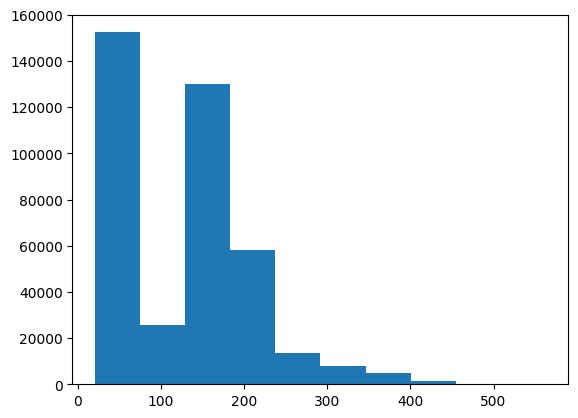

In [46]:
import matplotlib.pyplot as plt

lens = [len(i) for i in encoded]
lens = sorted(lens)
plt.hist(lens)

In [47]:
print(lens)

[21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,

In [ ]:
totalTokens=0
for i in encoded:
    totalTokens+=len(i)
print("totalTokens: {:.2f}".format(totalTokens/1e6), "M")


num_train = totalTokens//seq_len + 1

train_ids = encoded[:int(train_frac*len(encoded))]
val_ids = encoded[int(train_frac*len(encoded)):]
print("train_ids.shape: ", train_ids.shape)
print("val_ids.shape: ", val_ids.shape)

# export to bin files
train_ids = np.array(train_ids, dtype=np.uint16)
val_ids = np.array(val_ids, dtype=np.uint16)

train_ids.tofile(os.path.join(pth, 'data/{dataset}/train.bin'.format(dataset=dataset)))
val_ids.tofile(os.path.join(pth, 'data/{dataset}/val.bin'.format(dataset=dataset)))

In [38]:
import os
import bisect
from tqdm import trange

imgs = os.listdir('/home/li/basu_workspace/cptData/train2014')
print(imgs[0])
de
imgs = [img[15:] for img in imgs]
imgs = sorted(imgs)


for i in trange(len(dataset['train'])):
    img = dataset['train'][i]['image']
    if bisect.bisect_left(imgs, img) == len(imgs) or imgs[bisect.bisect_left(imgs, img)] != img:
        print(img, i)
        raise ValueError('img not found')

COCO_train2014_000000482499.jpg


NameError: name 'de' is not defined

In [ ]:
##print name of all parameters

for name, param in model.named_parameters():
    if 'bias' not in name:
        print(name[:-7])


In [ ]:
import torch
import safetensors
from safetensors.torch import save_model

save_model(model, 'my_model.safetensors')

# tensors = {}
# with safe_open("model.safetensors", framework="pt", device="cpu") as f:
#    for key in f.keys():
#        tensors[key] = f.get_tensor(key)

In [ ]:
import safetensors
safetensors.torch.load_model(model, 'my_model.safetensors')